In [1]:
# Let's import necessary lybraries
import torch
import numpy as np
from torch import nn
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs # For creating multiclass data
from sklearn.model_selection import train_test_split  # For spliting dataset

In [2]:
# Check torch version
torch.__version__

'1.13.0+cu116'

Specifically, let's do the following:

1. Create some multi-class data with make_blobs().
2. Turn the data into tensors (the default of make_blobs() is to use NumPy arrays).
3. Split the data into training and test sets using train_test_split().
4. Visualize the data.

In [3]:
# Set hyperparameters
NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED = 42

In [4]:
# Create data
X_blob, y_blob = make_blobs (n_samples = 1000,
                             n_features = NUM_FEATURES,
                             centers = NUM_CLASSES,
                             cluster_std = 1.5,
                             random_state = RANDOM_SEED)

In [5]:
# Let's check the sahpe of features and labels
X_blob.shape, y_blob.shape

((1000, 2), (1000,))

In [6]:
# Let's turn our data to tensor
X_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.LongTensor)

# Let's check shape again
X_blob.shape, y_blob.shape

(torch.Size([1000, 2]), torch.Size([1000]))

In [7]:
# Split data for train and test
X_blob_train, X_blob_test, y_blob_train, y_blob_test = train_test_split(X_blob,
                                                                        y_blob,
                                                                        test_size = 0.2,
                                                                        random_state=RANDOM_SEED)

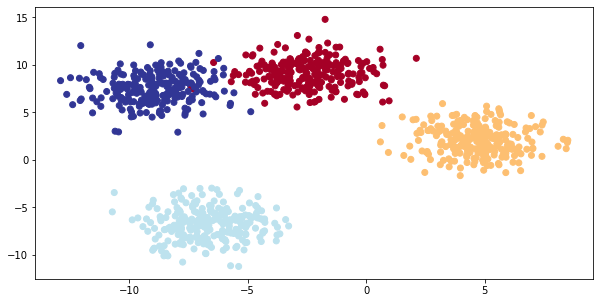

In [8]:
# Plot data
plt.figure(figsize = (10, 5))
plt.scatter(X_blob[:, 0], X_blob[:, 1], c=y_blob, cmap=plt.cm.RdYlBu);

In [9]:
# Let's chcek our class label
torch.unique(y_blob_train), torch.unique(y_blob_test)

(tensor([0, 1, 2, 3]), tensor([0, 1, 2, 3]))

## Multiclass classification model

In [10]:
# Device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [11]:
# Model
class BlobModel(nn.Module):
  def __init__(self, input_features, output_features, hidden_units = 8):
    super().__init__()
    self.linear_layer_stack = nn.Sequential(
        nn.Linear(in_features=input_features, out_features=hidden_units),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units, out_features=hidden_units),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units, out_features=output_features),
    )

  def forward(self, x):
    return(self.linear_layer_stack(x))


In [12]:
# Let's create a model instance and send to the target device

model_1 = BlobModel(input_features=2,
                   output_features = 4,
                   hidden_units = 8).to(device)

model_1

BlobModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=8, bias=True)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=4, bias=True)
  )
)

In [13]:
# Let's chcek model parameters
model_1.state_dict()

OrderedDict([('linear_layer_stack.0.weight', tensor([[ 0.5985,  0.6659],
                      [-0.1940, -0.1013],
                      [ 0.2918, -0.3292],
                      [ 0.3019, -0.6944],
                      [-0.6943,  0.1734],
                      [ 0.1842,  0.6175],
                      [ 0.5183, -0.2493],
                      [-0.2254,  0.3894]])),
             ('linear_layer_stack.0.bias',
              tensor([ 0.0949, -0.2372, -0.2890,  0.1654, -0.4513, -0.1201,  0.5098,  0.6834])),
             ('linear_layer_stack.2.weight',
              tensor([[-0.3093,  0.3312, -0.2415, -0.2531,  0.0351,  0.0837, -0.0908,  0.0388],
                      [ 0.2628, -0.1258, -0.2856, -0.0619,  0.0138,  0.1355, -0.2376, -0.0628],
                      [-0.3372, -0.3089,  0.1266,  0.0966,  0.1475, -0.2576,  0.2631, -0.0755],
                      [ 0.2111, -0.3016,  0.3059, -0.0660,  0.0584, -0.2404,  0.2855,  0.0263],
                      [ 0.0611,  0.0239, -0.2380,  0.3449, -0

In [14]:
# Set loss and optimizer
# Loss
loss_fn = torch.nn.CrossEntropyLoss()

# Optimizer
optimizer = torch.optim.SGD(params=model_1.parameters(), lr=0.1) # lr is a hyperparameter we can change

In [15]:
# Calculate accuracy (a classification metric)
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item() # torch.eq() calculates where two tensors are equal
    acc = (correct / len(y_pred)) * 100 
    return acc

### Getting prediction probabilities before training

> **Logits (Raw output of the model) -> Pred Probs -> Pred Labels**

In [16]:
# Logits from the model prediction raw outputs
model_1.eval()
with torch.inference_mode():

  logit = model_1(X_blob_test.to(device))
logit[:5]

tensor([[ 0.5893,  0.9470,  0.2309, -0.1912],
        [ 0.0712,  0.0411,  0.1873, -0.1042],
        [ 0.1613,  0.0355, -0.4499, -0.4885],
        [ 0.6479,  0.7426, -0.0082,  0.0616],
        [ 0.2598,  0.6231,  0.5186, -0.5014]])

In [17]:
# Use sigmoid on model to conver logits to prediction probabilities
pred_probs = torch.softmax(logit, dim=1)
pred_probs[:5]

tensor([[0.2788, 0.3987, 0.1948, 0.1277],
        [0.2543, 0.2467, 0.2856, 0.2134],
        [0.3394, 0.2993, 0.1842, 0.1772],
        [0.3150, 0.3463, 0.1634, 0.1753],
        [0.2381, 0.3424, 0.3084, 0.1112]])

In [18]:
pred_probs.shape

torch.Size([200, 4])

In [19]:
# Let's check out logits and pred_probs
print(f"Logits: {logit[:5]}")
print(f"\nPrediction Probabilities: {pred_probs[:5]}")

Logits: tensor([[ 0.5893,  0.9470,  0.2309, -0.1912],
        [ 0.0712,  0.0411,  0.1873, -0.1042],
        [ 0.1613,  0.0355, -0.4499, -0.4885],
        [ 0.6479,  0.7426, -0.0082,  0.0616],
        [ 0.2598,  0.6231,  0.5186, -0.5014]])

Prediction Probabilities: tensor([[0.2788, 0.3987, 0.1948, 0.1277],
        [0.2543, 0.2467, 0.2856, 0.2134],
        [0.3394, 0.2993, 0.1842, 0.1772],
        [0.3150, 0.3463, 0.1634, 0.1753],
        [0.2381, 0.3424, 0.3084, 0.1112]])


In [20]:
# Sum the first sample output of the softmax activation function 
print(f"Summation of first sample output: {torch.sum(pred_probs[0])}")
print(f"Maximum of first sample output: {torch.max(pred_probs[0])}")
print(f"Prediction index class of first sample output: {torch.argmax(pred_probs[0])}")

Summation of first sample output: 1.0
Maximum of first sample output: 0.3986753225326538
Prediction index class of first sample output: 1


In [21]:
# Comvert prediction probabilities to prediction's labes
preds = torch.argmax(pred_probs, dim=1)
preds[:5]

tensor([1, 2, 0, 1, 1])

In [22]:
# Ground truth
y_blob_test[:5]

tensor([1, 3, 2, 1, 0])

In [23]:
# Check equality
torch.eq(preds[:5], y_blob_test[:5])

tensor([ True, False, False,  True, False])

### Create training and testing loop

In [24]:
# Manual seed
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Epoch
epochs = 200

# Put the data to the target device
X_blob_train, y_blob_train = X_blob_train.to(device), y_blob_train.to(device)
X_blob_test, y_blob_test = X_blob_test.to(device), y_blob_test.to(device)

# Loop trouht the data

for epoch in range(epochs):

  #### Training loop
  model_1.train()

  # 1. Forward pass
  y_logits = model_1(X_blob_train)
  y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)

  # 2. Calculate the loss
  train_loss = loss_fn(y_logits, y_blob_train)
  train_acc = accuracy_fn(y_true = y_blob_train,
                    y_pred = y_pred)
  
  # 3. Optimizer zero grad
  optimizer.zero_grad()

  # 4. Loss backward
  train_loss.backward()

  # 5. Optimizer step()
  optimizer.step()

  #### Test Loop
  model_1.eval()

  with torch.inference_mode():

    # 1. Forward pass
    test_logit = model_1(X_blob_test)
    test_pred = torch.softmax(test_logit, dim=1).argmax(dim=1)

    # 2. Loss calculation
    test_loss = loss_fn(test_logit, y_blob_test)
    test_acc = accuracy_fn(y_true = y_blob_test,
                    y_pred = test_pred)
    
  # Print out what's happen
  if epoch % 10 == 0:
    print(f"Epoch: {epoch} | Train Loss: {train_loss:.4f} | Train Accuracy: {train_acc:.2f}% | Test Loss: {test_loss:.4f} | Test Accuracy: {test_acc:.2f}%")


Epoch: 0 | Train Loss: 1.3908 | Train Accuracy: 24.50% | Test Loss: 1.2961 | Test Accuracy: 34.00%
Epoch: 10 | Train Loss: 0.7508 | Train Accuracy: 70.88% | Test Loss: 0.7201 | Test Accuracy: 71.50%
Epoch: 20 | Train Loss: 0.3951 | Train Accuracy: 92.88% | Test Loss: 0.3754 | Test Accuracy: 94.50%
Epoch: 30 | Train Loss: 0.1465 | Train Accuracy: 99.12% | Test Loss: 0.1293 | Test Accuracy: 99.50%
Epoch: 40 | Train Loss: 0.0759 | Train Accuracy: 99.00% | Test Loss: 0.0659 | Test Accuracy: 99.50%
Epoch: 50 | Train Loss: 0.0564 | Train Accuracy: 99.00% | Test Loss: 0.0474 | Test Accuracy: 99.50%
Epoch: 60 | Train Loss: 0.0475 | Train Accuracy: 99.00% | Test Loss: 0.0386 | Test Accuracy: 99.50%
Epoch: 70 | Train Loss: 0.0423 | Train Accuracy: 99.12% | Test Loss: 0.0334 | Test Accuracy: 99.50%
Epoch: 80 | Train Loss: 0.0388 | Train Accuracy: 99.12% | Test Loss: 0.0299 | Test Accuracy: 99.50%
Epoch: 90 | Train Loss: 0.0364 | Train Accuracy: 99.12% | Test Loss: 0.0274 | Test Accuracy: 99.50%
E

In [25]:
# Plot predctions function 
import requests
from pathlib import Path 

# Download helper functions from Learn PyTorch repo (if not already downloaded)
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Downloading helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary

In [26]:
# Let's make prediction after training
model_1.eval()
with torch.inference_mode():
  y_logits = model_1(X_blob_test)
  y_preds = torch.softmax(y_logits, dim=1).argmax(dim=1)

In [27]:
# Let's print first 10 predictions from logits
y_logits[:10]

tensor([[  4.2132,  11.6765,  -2.6734,  -8.2452],
        [  2.1976, -10.1537,   0.2762,   8.4406],
        [ -5.1024,  -0.5869,   7.3872,  -0.7979],
        [  1.8919,   7.9021,  -1.3777,  -4.7780],
        [  8.7011,   3.0266,  -5.0713,  -3.7087],
        [  2.1677, -12.1595,   0.7740,  10.1352],
        [ -4.6078,  -0.2819,   6.2258,  -1.1191],
        [  7.5520,  -1.1762,  -4.5560,  -0.2654],
        [ -6.0684,  -1.2839,   9.4081,  -0.1868],
        [  7.9487,   0.2897,  -4.6747,  -1.3995]])

In [28]:
# Let's print first 10 predictions from predction probabilities
y_preds[:10]

tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0])

In [29]:
# Print ground truth values and compare
print(f"Ground Truth Values: {y_blob_test[:10]}")

# Compare
print(f"Comparison: {torch.eq(y_preds[:10], y_blob_test[:10])}")

Ground Truth Values: tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0])
Comparison: tensor([True, True, True, True, True, True, True, True, True, True])


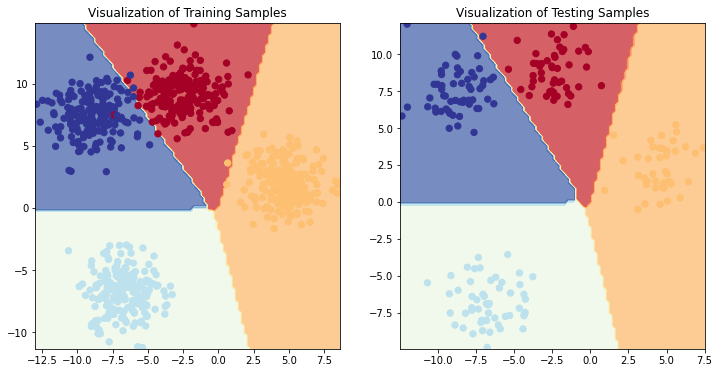

In [30]:
# Visualization
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Visualization of Training Samples")
plot_decision_boundary(model_1, X_blob_train, y_blob_train)

plt.subplot(1, 2, 2)
plt.title("Visualization of Testing Samples")
plot_decision_boundary(model_1, X_blob_test, y_blob_test)

## Few more classification metrics to evalute our model
1. **Accuracy** ( For balance dataset)
2. **Precision**(For imbalance dataset)
3. **Recall** (For imbalance dataset)
4. **Confusion matrix**
5. **Classification report**
6. **F1-score**

* link -. https://willkoehrsen.github.io/statistics/learning/beyond-accuracy-precision-and-recall/

* Precision Recall Tradeoff -> https://medium.com/analytics-vidhya/precision-recall-tradeoff-79e892d43134

* Torchmetrics -> https://torchmetrics.readthedocs.io/en/stable/

In [ ]:
# Inatall torchmetrics
!pip install torchmetrics

In [34]:
# Import Accuracy
from torchmetrics import Accuracy

# Setup metric and make sure it's on the target device
torchmetrics_accuracy = Accuracy(task='multiclass', num_classes=4).to(device)

# Calculate accuracy
torchmetrics_accuracy(y_preds, y_blob_test)

tensor(0.9950)